In [1]:
# import the necessary packages
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop

from keras.preprocessing.image import ImageDataGenerator
import numpy as np

np.random.seed(1671)  # for reproducibility

from keras.layers.normalization import BatchNormalization
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
def load_and_format(in_path):
    out_df = pd.read_json(in_path)
    out_images = out_df.apply(lambda c_row: [np.stack([c_row['band_1'],c_row['band_2']], -1).reshape((75,75,2))],1)
    out_images = np.stack(out_images).squeeze()
    return out_df, out_images


In [3]:
base_path = 'data/iceberg'

In [4]:
train_df, train_images = load_and_format(os.path.join(base_path, 'train.json'))
print('training', train_df.shape, 'loaded', train_images.shape)
test_df, test_images = load_and_format(os.path.join(base_path, 'test.json'))
print('testing', test_df.shape, 'loaded', test_images.shape)
train_df.sample(3)

training (1604, 5) loaded (1604, 75, 75, 2)
testing (8424, 4) loaded (8424, 75, 75, 2)


,band_1,band_2,id,inc_angle,is_iceberg
1343,"[-26.883247, -25.079762, -27.578579, -28.73846...","[-29.162113, -29.162159, -28.738419, -29.60777...",5fe2d101,43.1073,0
1258,"[-19.872192, -19.733278, -23.464474, -22.46505...","[-23.898735, -25.617088, -28.871698, -31.63781...",0f962f75,37.2802,1
102,"[-22.781437, -25.155306, -25.407164, -24.91069...","[-25.933594, -25.933668, -22.97249, -22.97249,...",68a80de0,33.6352,1


In [5]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
X_train, X_test, y_train, y_test = train_test_split(train_images,
                                                   to_categorical(train_df['is_iceberg']),
                                                    random_state = 2017,
                                                    test_size = 0.5
                                                   )
print('Train', X_train.shape, y_train.shape)
print('Validation', X_test.shape, y_test.shape)

Train (802, 75, 75, 2) (802, 2)
Validation (802, 75, 75, 2) (802, 2)


In [6]:
# float and normalization
#X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')
#X_train /= 255
#X_test /= 255

In [8]:
# network and training
NB_EPOCH = 5
BATCH_SIZE = 16
VERBOSE = 1
OPTIMIZER = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
VALIDATION_SPLIT=0.2

IMG_ROWS, IMG_COLS = 75, 75 # input image dimensions
IMG_CHANNELS = 2 # channels
NB_CLASSES = 2  # number of outputs = number of digits
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, IMG_CHANNELS)

In [9]:
# network

model = Sequential()

 
model.add(Conv2D(32, kernel_size=(3,3), padding='same',
                        input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS)))
model.add(BatchNormalization(momentum = 0.99))
model.add(Activation('relu'))
model.add(Conv2D(32, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Conv2D(64, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization(momentum = 0.99))
model.add(Activation('relu'))
model.add(Conv2D(64, 3, 3))

model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation="sigmoid"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 75, 32)        608       
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 75, 75, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 32)        0         
__________

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`


In [15]:
# initialize the optimizer and model

model.compile(loss="binary_crossentropy", optimizer=OPTIMIZER,
	metrics=["accuracy"])

In [16]:
X_train = np.array(X_train)

In [13]:
datagen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 40)

datagen.fit(X_train)


ValueError: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (802, 75, 75, 2) (2 channels).

In [17]:
# train
#optim = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE,
	epochs=NB_EPOCH, validation_split=VALIDATION_SPLIT, 
	verbose=VERBOSE)
 
print('Testing...')
score = model.evaluate(X_test, y_test,
                     batch_size=BATCH_SIZE, verbose=VERBOSE)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])

#server.launch(model)


Train on 641 samples, validate on 161 samples
Epoch 1/5
641/641 [==============================] - 3s - loss: 1.7147 - acc: 0.5702 - val_loss: 0.6380 - val_acc: 0.7174
Epoch 2/5
641/641 [==============================] - 1s - loss: 0.5885 - acc: 0.6591 - val_loss: 0.5497 - val_acc: 0.7205
Epoch 3/5
641/641 [==============================] - 1s - loss: 0.5342 - acc: 0.7223 - val_loss: 0.6099 - val_acc: 0.5466
Epoch 4/5
641/641 [==============================] - 1s - loss: 0.5002 - acc: 0.7418 - val_loss: 1.7181 - val_acc: 0.5217
Epoch 5/5
641/641 [==============================] - 1s - loss: 0.4543 - acc: 0.7785 - val_loss: 3.0153 - val_acc: 0.5186
Testing...
802/802 [==============================] - 0s     

Test score: 2.81775311401
Test accuracy: 0.538653366584


In [ ]:
#save model
#model_json = model.to_json()
#open('iceberg_architecture.json', 'w').write(model_json)
#model.save_weights('iceberg_weights.h5', overwrite=True)

dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])


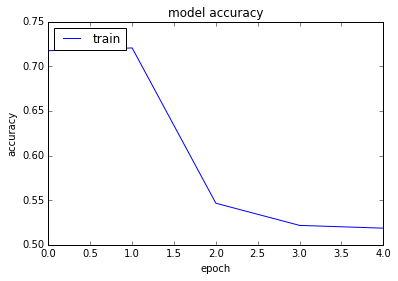

In [18]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
#plt.plot(mo)
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


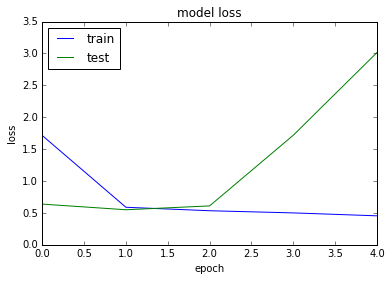

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
test_predictions = model.predict(test_images)

In [ ]:
pred_df = test_df[['id']].copy()
pred_df['is_iceberg'] = test_predictions[:,1]
pred_df.to_csv('predictions.csv', index = False)
pred_df.sample(10)